# Introduction

With the advance of deep learning, computers can now compose music using trained models based on the sample pieces. This not only allows artists that are lack of the domain knowledge to accomplish their ideas, but also provides possible creative styles and patterns that may foster the composer's creative process. 

In the project, a Recurrent Neural Network (RNN) model is built using LSTM and dense layers. The model is then trained on 10 of Frédéric Chopin's Valse and Waltz pieces in MIDI format downloaded from [*kunstderfuge.com*](http://www.kunstderfuge.com/chopin.htm). The MIDI files are converted to numeric, sequential data and fed into the RNN for training. The trained RNN reads a pattern of notes, then generates new notes based on the sequence. 

Moreover, to explore different styles of piano pieces, a dataset of 8 Nocturne pieces by Frédéric Chopin downloaded from [*8notes.com*](https://www.8notes.com/school/search_fsm.asp?keyword=chopin+nocturne&x=0&y=0&pageA=1) are used to train a complete seperate RNN model. The generated sample pieces from the Valse model and the Nocturne model can be found [here](https://drive.google.com/drive/folders/1EtkZnCGtkbKOGfVaamLZjXdWjsgXqizi?usp=sharing).  


# Data Preprocessing

Import necessary libraries and collect data files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# need python3.XX-dev, libasound2-dev deb packages
from music21 import converter, instrument, note, chord, stream
from timidity import Parser, play_notes

import pickle
import glob

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten, Embedding
from keras.callbacks import ModelCheckpoint

2025-05-23 17:03:32.696571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748000012.713823  312769 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748000012.719092  312769 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-23 17:03:32.738564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
valseMusic = glob.glob('Nocturnes Dataset/*.mid')
valseMusic

['Nocturnes Dataset/Nocturne_Opus_72_No_1_in_E_Minor.mid',
 'Nocturnes Dataset/chop32n2.mid',
 'Nocturnes Dataset/chopin_Nocturne_b49.mid',
 'Nocturnes Dataset/chopin_cminor_nocturne_b108_PNO.mid',
 'Nocturnes Dataset/chopin_nocturne_9_2.mid',
 'Nocturnes Dataset/chopin_nocturneop9nr1.mid',
 'Nocturnes Dataset/chopin_op55_1.mid',
 'Nocturnes Dataset/chopin_op55_2.mid']

Using the *music21* library, the MIDI files are first parsed into single instrument track of notes and chords, then chords are further broken down into groups of notes. The MIDI files are concatenated and are eventually converted to a sequence of notes.

In [3]:
processedNotes = []

for valse in valseMusic:
    
    # parse Midi
    valse = converter.parse(valse)
    
    # Handle cases for multi-instruments
    try:
        parts = instrument.partitionByInstrument(valse)
        notes = parts.parts[0].recurse()
    except:
        notes = valse.flat.notes
    
    # Handle chords
    for singleNote in notes:
        if isinstance(singleNote, chord.Chord):
            processedNotes.append('.'.join(str(norm) for norm in singleNote.normalOrder))
        elif isinstance(singleNote, note.Note):
            processedNotes.append(str(singleNote.pitch))

# Save a notes library
with open('nocturnesNotesLibrary', 'wb') as file:
    pickle.dump(processedNotes, file)

In [4]:
len(processedNotes), processedNotes[:10]

(6331, ['E2', 'B2', 'G3', 'E3', 'C4', 'B3', 'E2', 'B2', 'G3', 'E3'])

Furthermore, each unique note/pitch is assigned with a unique number. The sequence of notes is then divided into subsequences, each containing the numeric representation of 100 notes. The training data that is fed into the network is then sequences of 100 numbers, each representing a corresponding note. The label/output of each input sequence is the next note that is after the 100-note sequence, also represented by a number.

In [5]:
SEQSIZE = 100

alphabetSize = len(set(processedNotes))

# Find unique pitches
pitches = sorted(set(processedNote for processedNote in processedNotes))

# a dict to convert each unique note to a unique number.
dictRef = dict((pitch, num) for num, pitch in enumerate(pitches))

inputNotes = []
outputNotes = []

# Divide sequence into subsequences of 100 notes, then convert notes to numbers
for i in range(0, len(processedNotes) - SEQSIZE):
    batchInput = processedNotes[i: i+SEQSIZE]
    batchOutput = processedNotes[i+SEQSIZE]
    inputNotes.append([dictRef[n] for n in batchInput])
    outputNotes.append([dictRef[batchOutput]])

# reshape the input and normalize, convert output to categorical.
batchNum = len(inputNotes)
inputNotes = np.reshape(inputNotes, (batchNum, SEQSIZE, 1)) / float(alphabetSize)
outputNotes = to_categorical(outputNotes)

In [6]:
inputNotes[0][95:]

array([[0.80363636],
       [0.86909091],
       [0.96727273],
       [0.94181818],
       [0.93818182]])

In [11]:
# Notes (pitch) to Index
dictRef.items()

dict_items([('0', 0), ('0.1', 1), ('0.1.3', 2), ('0.1.5', 3), ('0.1.6', 4), ('0.2', 5), ('0.2.5', 6), ('0.2.5.6', 7), ('0.2.5.8', 8), ('0.3', 9), ('0.3.4', 10), ('0.3.5', 11), ('0.3.6', 12), ('0.3.7', 13), ('0.4', 14), ('0.4.6', 15), ('0.4.7', 16), ('0.5', 17), ('0.6', 18), ('1', 19), ('1.2', 20), ('1.2.4', 21), ('1.2.6', 22), ('1.2.7', 23), ('1.3', 24), ('1.3.4', 25), ('1.3.8', 26), ('1.4', 27), ('1.4.8', 28), ('1.5', 29), ('1.5.7', 30), ('1.5.8', 31), ('1.6', 32), ('1.7', 33), ('10', 34), ('10.0', 35), ('10.0.3', 36), ('10.0.4', 37), ('10.0.5', 38), ('10.1', 39), ('10.1.2', 40), ('10.1.5', 41), ('10.11', 42), ('10.11.0', 43), ('10.11.1', 44), ('10.2', 45), ('10.2.5', 46), ('10.3', 47), ('11', 48), ('11.0', 49), ('11.0.1', 50), ('11.0.2', 51), ('11.0.2.5', 52), ('11.0.2.5.7', 53), ('11.0.4', 54), ('11.0.5', 55), ('11.1', 56), ('11.1.2', 57), ('11.1.3', 58), ('11.1.4', 59), ('11.1.5', 60), ('11.1.6', 61), ('11.2', 62), ('11.2.4', 63), ('11.2.5', 64), ('11.2.5.7', 65), ('11.2.6', 66), (

# RNN Model Training

The design of the RNN model is traditional and is structured as follows. Two LSTM-and-Dropout groups are followed by two densely-connected layers, also accompanied by Dropout layers. The output activation function is softmax. Since this is a single-label classification task, categorical crossentropy loss is used. 

In [ ]:
inputNotes.shape[0]

(100, 1)

In [ ]:
from tensorflow.keras.layers import Input

def createRNNModel(inputNotes, outputNum):
    
    rnnModel = Sequential([
        LSTM(128, 
             #input_shape=inputNotes.shape[1:],
             return_sequences=True, 
             recurrent_initializer='glorot_uniform',
             recurrent_activation='sigmoid'), 
        Dropout(0.2),

        LSTM(128, 
             return_sequences=True,
             recurrent_initializer='glorot_uniform',
             recurrent_activation='sigmoid'), 
        Dropout(0.2),

        Flatten(),
        Dropout(0.2),
        Dense(256),
        Dropout(0.2),

        Dense(outputNum, activation='softmax')
    ])
    
    rnnModel.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return rnnModel
    
rnnModel = createRNNModel(inputNotes, alphabetSize)

To ensure the style is mapped, the model is trained with 500 epochs. It is worth mentioning that since there are such great varieties in the labels, validation and early stopping mechanisms are not used.

In [23]:
checkpointCallback = ModelCheckpoint('ChopinNocturnesLSTMx2.keras', monitor='loss', 
                             verbose=2, save_best_only=True)
rnnModel.fit(inputNotes, outputNotes, epochs=300, batch_size=32, callbacks=[checkpointCallback])
rnnModel.summary()

Epoch 1/300


I0000 00:00:1748000317.370697  316338 cuda_dnn.cc:529] Loaded cuDNN version 90300


193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9920
Epoch 1: loss improved from inf to 4.86673, saving model to ChopinNocturnesLSTMx2.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.9901
Epoch 2/300
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7723
Epoch 2: loss improved from 4.86673 to 4.75564, saving model to ChopinNocturnesLSTMx2.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.7721
Epoch 3/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6683
Epoch 3: loss improved from 4.75564 to 4.68214, saving model to ChopinNocturnesLSTMx2.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.6684
Epoch 4/300
193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5721
Epoch 4: loss improved from 4.68214 to 4.58796, saving model to ChopinNocturnesLSTMx2.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.5723
Epoch 5/300
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4692
Epoch 5: loss improved from 4.58796 to 4.50393, saving model to ChopinNoctu

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 275)            │        70,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,627 (40.58 MB)

 Trainable params: 3,545,875 (13.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,091,752 (27.05 MB)

<Axes: >

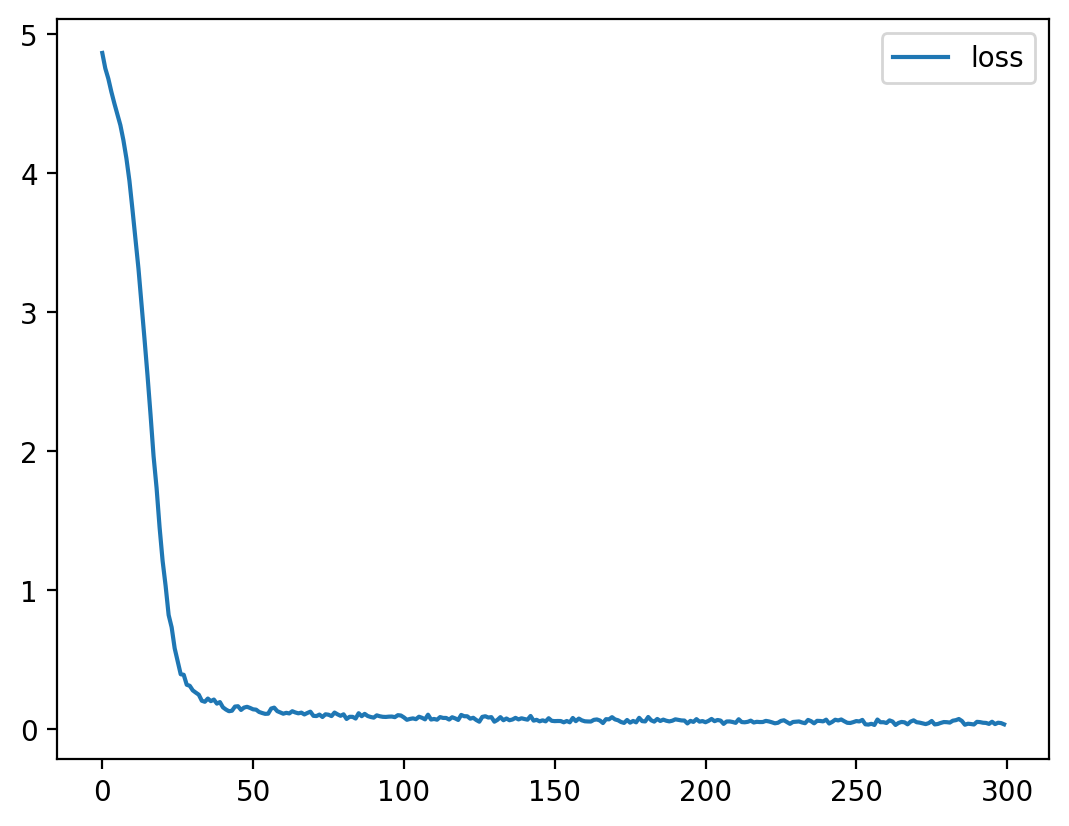

In [24]:
modelLoss = pd.DataFrame(rnnModel.history.history)
modelLoss.plot()

# Music Generation

After the weights are re-loaded into the model, five sequences of 100 numbers, each representing a 100-note sequence, are randomly drawn to be the input data for model prediction. 

In [ ]:
from tensorflow.keras.models import load_model

SEQSIZE = 100

# Set up prediction input by mapping notes to integers.
inputNotes = []

for i in range(0, len(notes) - SEQSIZE):
    batchInput = processedNotes[i: i+SEQSIZE]
    inputNotes.append([dictRef[n] for n in batchInput])

# reshape input and normalize
batchNum = len(inputNotes)    
inputNotes = np.reshape(inputNotes, (batchNum, SEQSIZE, 1)) / float(alphabetSize)

# create model using weight.
#rnnModel2 = createRNNModel(inputNotes, alphabetSize)
#rnnModel2.load_weights('ChopinNocturnesLSTMx2.keras')

# load the best model.
rnnModel2 = load_model('ChopinNocturnesLSTMx2.keras')

# inputs: 5 random sequences
patterns = []
for i in range(0, 5):
    startNote = np.random.randint(0, len(inputNotes)-1)
    patterns.append(list(inputNotes[startNote]))
    
dictRefReverse = dict((num, pitch) for num, pitch in enumerate(pitches))

5 predictions are made based on the 5 randomly selected input sequences. Each input is first reshaped and normalized before fed into the model. The prediction output is then converted to a note, and is used to generate the next note as part of the input sequence.

In [29]:
from copy import deepcopy
songs = [[], [], [], [], []]

# predict, generate output notes.
# Generate 5 songs, each song has 800 notes.
for j in range(5):
    pat = deepcopy(patterns[j])

    for _ in range(100):
        # reshape input and predict
        #print(pat[95:])
        predIn = np.reshape(pat, (1, len(pat), 1)) #/ float(alphabetSize)
        prediction = rnnModel2.predict(predIn, verbose=0)
        
        # Convert prediction back to notes
        index = np.argmax(prediction)
        prediction = dictRefReverse[index]
        
        # append to output, and use the new note for further generation.
        songs[j].append(prediction)
        #print(prediction, end=" ")
        pat.append(np.array([index/alphabetSize]))
        pat = pat[1: len(pat)]
    print('{} song created.'.format(j+1))

1 song created.
2 song created.
3 song created.
4 song created.
5 song created.


The prediction outputs, each from a sequence of notes, are converted back to a stream of MIDI data. 

In [30]:
def generateMidi(outputNotes, fileName):
    offset = 0
    midiOutput = []

    for notePat in outputNotes:

        # It is a chord.
        if ('.' in notePat) or notePat.isdigit():

                # Split to notes
                notes_in_chord = notePat.split('.')
                notes = []

                # chord as notes
                for eachNote in notes_in_chord:
                    new_note = note.Note(int(eachNote))
                    new_note.storedInstrument = instrument.Piano()
                    notes.append(new_note)

                # Convert to midi chord and store
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                midiOutput.append(new_chord)

        # pattern is a note
        else:
            # Convert to midi note and store
            new_note = note.Note(notePat)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            midiOutput.append(new_note)

        # increase offset to make sure notes do not stack
        offset += 0.5

    # Convert to midi stream
    midiOutput = stream.Stream(midiOutput)
    midiOutput.write('midi', fp=fileName)
    
for num, song in enumerate(songs):
    generateMidi(song, 'ChopinNocturnesGenerated_{}.mid'.format(num))


In [54]:
# Listen to the midi music, uncomment the file wish to listen.
# ps = Parser("ChopinValseGenerated_0.mid")
# ps = Parser("ChopinValseGenerated_1.mid")
# ps = Parser("ChopinValseGenerated_2.mid")
# ps = Parser("ChopinValseGenerated_3.mid")
# ps = Parser("ChopinValseGenerated_4.mid")
# ps = Parser("ChopinNocturnesGenerated_0.mid")
# ps = Parser("ChopinNocturnesGenerated_1.mid")
# ps = Parser("ChopinNocturnesGenerated_2.mid")
# ps = Parser("ChopinNocturnesGenerated_3.mid")
ps = Parser("ChopinNocturnesGenerated_4.mid")

play_notes(*ps.parse(), np.sin)

Created MIDI parser on file ChopinNocturnesGenerated_4.mid
BPM: 120
Time Signature: 4 / 4
Arranging notes... 132 / 132
Playing song...


(array([    0,   147,   295, ..., -4170, -4164, -4158], dtype=int16),
 <simpleaudio.shiny.PlayObject at 0x77764e8675b0>)

# Conclusion

Music generation is a new emerging field with recent advance in deep learning. As a crossroad of technology and art, it extends the ability of artists and brings new elements of style and tempo into music creation. In this music generation project, an LSTM-based RNN model is designed, implemented and trained with a set of 10 Chopin's Valse, and separately, a set of 8 Chopin's Nocturnes. While the generated music pieces are definitely of no match to Frédéric Chopin's original pieces, it provides an insight to the ability of deep learning in art generation, and has proven that music pieces generated by deep learning models are non-trivial and possess a considerable degree of artistic values.